In [56]:
!python3 -m pip install --upgrade pip

In [57]:
!pip install sentencepiece

In [58]:
DATASET_PATH = './data.csv'

In [59]:
import pandas as pd
import numpy as np

In [60]:
df = pd.read_csv(DATASET_PATH)
df.head()

,title,cleanBody,category
0,"""아시안 증오를 멈춰라""…미 전역서 규탄·추모 시위","[앵커] 애틀랜타 총격 사건으로 미국 시민들은 또한번 거리로 나왔습니다. 슬프고, ...",international
1,"한인 4명 신원 공개…희생자 아들 ""명백한 증오범죄""",[앵커] 이번 사건에서 희생된 한인 4명의 신원이 사흘 만에 공개됐습니다. 유가족과...,international
2,오늘(12일) 소상공인 버팀목자금 '짝수' 신청날…13일부터 모두 신청,12일 오전 8시부터 '버팀목자금.kr'을 통해 짝수 소상공인들로부터 버팀목자금 신...,economy
3,"""노래방에서 혼자 노래 중입니다""…새벽에도 들어온 '버팀목자금'",11일 오후 서울 황학동 중앙시장 중고가전제품 판매점에 진열된 TV에서 문재인 대통...,economy
4,'실종 2주째' 고양시 발달장애인 점퍼 한강서 발견,'실종 2주째' 고양시 발달장애인 점퍼 한강서 발견 경기 고양시 행주산성둘레길에서 ...,society


<AxesSubplot:>

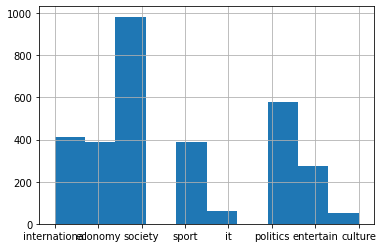

In [61]:
df['category'].hist()

<AxesSubplot:>

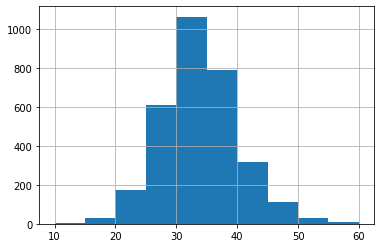

In [62]:
df['title'].str.len().hist()

<AxesSubplot:>

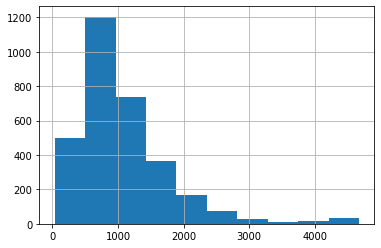

In [63]:
df['cleanBody'].str.len().hist()

In [64]:
ko_train = df['title'].tolist()
ko_train[:10]

['"아시안 증오를 멈춰라"…미 전역서 규탄·추모 시위',
 '한인 4명 신원 공개…희생자 아들 "명백한 증오범죄"',
 "오늘(12일) 소상공인 버팀목자금 '짝수' 신청날…13일부터 모두 신청",
 '"노래방에서 혼자 노래 중입니다"…새벽에도 들어온 \'버팀목자금\'',
 "'실종 2주째' 고양시 발달장애인 점퍼 한강서 발견",
 '공군부대, 125만원 치킨먹고 환불에 별점 테러 의혹',
 "'치킨 125만 원' 환불 받은 공군부대가 남긴 별점",
 '키움 이정후, 김하성 넘었다…5억5천만원 5년차 최고연봉 경신',
 "2021 KLPGA투어, 총31개 대회 '역대최고 총상금 280억원' 확정",
 "기관vs개미 대혈투에 증시는 '빅뱅'...개미 한달 치 화력 하루에 몰빵"]

In [65]:
category = df['category'].tolist()
bodytext = df['cleanBody'].tolist()
print(len(category), len(bodytext))

3138 3138


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

import sentencepiece as spm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import os

In [67]:
with open('src.txt', mode='w', encoding='utf-8-sig') as f :
    f.write('\n'.join(df['title']))
with open('src2.txt', mode='w', encoding='utf-8-sig') as f :
    f.write('\n'.join(df['cleanBody']))
with open('trg.txt', mode='w', encoding='utf-8-sig') as f :
    f.write('\n'.join(df['category']))

In [68]:
max(df['title'].str.split().str.len())

15

In [69]:
max(df['title'].str.len())

60

In [70]:
# 문장 토큰화 - title

corpus = 'src.txt'
prefix = 'src'

VOCAB_SIZE = 15*100*8
SEQ_LEN = 60*2

spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={VOCAB_SIZE}" +
    " --model_type=bpe" + 
    f" --max_sentence_length={SEQ_LEN}" +
    " --pad_id=0 --pad_piece=[PAD]" +
    " --unk_id=1 --unk_piece=[UNK]" +
    " --bos_id=2 --bos_piece=[BOS]" +
    " --eos_id=3 --eos_piece=[EOS]" +
    " --user_defined_symbols=[SEP],[CLS],[MASK]"
)

In [71]:
# 정수화
sp_src = spm.SentencePieceProcessor()
sp_src.Load('src.model')

for idx in range(3) :
    sentence = df['title'][idx]
    print(df['title'][idx])
    print(sp_src.EncodeAsPieces(sentence))
    print(sp_src.EncodeAsIds(sentence))

"아시안 증오를 멈춰라"…미 전역서 규탄·추모 시위
['▁"', '아', '시안', '▁증오를', '▁멈춰', '라', '"...', '미', '▁전역서', '▁규탄', '·', '추', '모', '▁시위']
[10, 10872, 4844, 8755, 5078, 10911, 62, 10900, 8004, 2614, 10857, 10948, 10959, 1092]
한인 4명 신원 공개…희생자 아들 "명백한 증오범죄"
['▁한인', '▁4', '명', '▁신', '원', '▁공개', '...', '희', '생', '자', '▁아들', '▁"', '명', '백', '한', '▁증오범죄', '"']
[5595, 56, 10859, 39, 10854, 190, 8, 11121, 10978, 10860, 980, 10, 10859, 10946, 10868, 6983, 10833]
오늘(12일) 소상공인 버팀목자금 '짝수' 신청날…13일부터 모두 신청
['▁오늘', '(12', '일', ')', '▁소상공인', '▁버팀목자금', "▁'", '짝', '수', "'", '▁신청', '날', '...1', '3', '일부터', '▁모두', '▁신청']
[149, 8207, 10880, 10981, 2273, 4170, 9, 11510, 10848, 10834, 601, 11119, 469, 10881, 707, 554, 601]


In [72]:
max(df['cleanBody'].str.split().str.len())

1108

In [73]:
max(df['cleanBody'].str.len())

4674

In [74]:
# 문장 토큰화 - body

corpus = 'src2.txt'
prefix = 'src2'

VOCAB_SIZE2 = 1108*8
SEQ_LEN2 = 4674*2


spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={VOCAB_SIZE2}" +
    " --model_type=bpe" + 
    f" --max_sentence_length={SEQ_LEN2}" +
    " --pad_id=0 --pad_piece=[PAD]" +
    " --unk_id=1 --unk_piece=[UNK]" +
    " --bos_id=2 --bos_piece=[BOS]" +
    " --eos_id=3 --eos_piece=[EOS]" +
    " --user_defined_symbols=[SEP],[CLS],[MASK]"
)

In [75]:
# 정수화
sp_src2 = spm.SentencePieceProcessor()
sp_src2.Load('src.model')

for idx in range(3) :
    sentence = df['title'][idx]
    print(df['title'][idx])
    print(sp_src.EncodeAsPieces(sentence))
    print(sp_src.EncodeAsIds(sentence))

"아시안 증오를 멈춰라"…미 전역서 규탄·추모 시위
['▁"', '아', '시안', '▁증오를', '▁멈춰', '라', '"...', '미', '▁전역서', '▁규탄', '·', '추', '모', '▁시위']
[10, 10872, 4844, 8755, 5078, 10911, 62, 10900, 8004, 2614, 10857, 10948, 10959, 1092]
한인 4명 신원 공개…희생자 아들 "명백한 증오범죄"
['▁한인', '▁4', '명', '▁신', '원', '▁공개', '...', '희', '생', '자', '▁아들', '▁"', '명', '백', '한', '▁증오범죄', '"']
[5595, 56, 10859, 39, 10854, 190, 8, 11121, 10978, 10860, 980, 10, 10859, 10946, 10868, 6983, 10833]
오늘(12일) 소상공인 버팀목자금 '짝수' 신청날…13일부터 모두 신청
['▁오늘', '(12', '일', ')', '▁소상공인', '▁버팀목자금', "▁'", '짝', '수', "'", '▁신청', '날', '...1', '3', '일부터', '▁모두', '▁신청']
[149, 8207, 10880, 10981, 2273, 4170, 9, 11510, 10848, 10834, 601, 11119, 469, 10881, 707, 554, 601]


In [76]:
def encoder1(tmpstr:str) -> np.array :
    tmpstr = np.array(sp_src.EncodeAsIds(tmpstr))
 
    if len(tmpstr) > SEQ_LEN :
        tmpstr = tmpstr[:SEQ_LEN]
   
    else :
        tmpstr = np.pad(tmpstr, (0, SEQ_LEN - len(tmpstr)), 'constant', constant_values = sp_src.pad_id())
    
    return tmpstr

def encoder2(tmpstr:str) -> np.array :
    tmpstr = np.array(sp_src2.EncodeAsIds(tmpstr))
 
    if len(tmpstr) > SEQ_LEN2 :
        tmpstr = tmpstr[:SEQ_LEN2]
   
    else :
        tmpstr = np.pad(tmpstr, (0, SEQ_LEN - len(tmpstr)), 'constant', constant_values = sp_src.pad_id())
    
    return tmpstr


In [77]:
src_data = df['title']

src_list = []

for idx in range(len(src_data)):
    src_list.append(encoder1(src_data[idx]))

src_list[0]

array([   10, 10872,  4844,  8755,  5078, 10911,    62, 10900,  8004,
        2614, 10857, 10948, 10959,  1092,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [78]:
src_data2 = df['cleanBody']

src_list2 = []

for idx in range(len(src_data2)):
    src_list2.append(encoder1(src_data2[idx]))

src_list2[0]

array([   12,  4534, 10871,  1857,   702,   528,    85,   370,   876,
        2394,   171, 10868, 11104,  6221,  5626,  3866, 10832,  5110,
       10990, 10864, 10835,   148,  3117, 10835,  9152, 11329,    31,
        4844,  8755,  1890, 10948,  4299,   242, 11511,  3866, 10832,
         191,   163, 10851,  9359, 11016, 11290,   812,    10,  4656,
        1400,    24, 11117, 10836,  3535, 10833, 11329,    10, 10931,
       10923, 10842,  5625, 10983,  1498, 10833, 10864,  9350, 11290,
         764, 11458,  3866, 10832,  2081,    39, 10863,    44,  2500,
         290,  2192,   160,  2741,  3155,  8364, 10832,    12, 10846,
       10860, 10871,     9, 10872,  4844,  8755,  5078, 10911, 10834,
       10888,   132, 10890, 11290,  3043, 10852,  2760, 10836,    47,
       10944, 11118,   772, 10858, 11329,   292, 11212,  1178, 10832,
         183, 10840,   311,   743, 10880,   232, 11057, 10842,  5440,
          49,  1986, 10836])

In [80]:
src_train, src_valid, trg_train, trg_valid = train_test_split(src_list, category, test_size=0.2, random_state=42)

In [81]:
src_train2, src_valid2, trg_train2, trg_valid2 = train_test_split(src_list2, category, test_size=0.2, random_state=42)

In [82]:
joblib.dump(src_train, 'src_train.pkl')
joblib.dump(trg_train, 'trg_train.pkl')
joblib.dump(src_valid, 'src_valid.pkl')
joblib.dump(trg_valid, 'trg_valid.pkl')
joblib.dump(src_list, 'src_list.pkl')
joblib.dump(category, 'trg_list.pkl')

['trg_list.pkl']

In [83]:
joblib.dump(src_train2, 'src_train2.pkl')
joblib.dump(trg_train2, 'trg_train2.pkl')
joblib.dump(src_valid2, 'src_valid2.pkl')
joblib.dump(trg_valid2, 'trg_valid2.pkl')
joblib.dump(src_list2, 'src_list2.pkl')

['src_list2.pkl']